# CSE 156 FA24: NLP UCSD PA3:

## Retrieval-Augmented Generation (RAG) (40 points)

The goal of this assignment is to gain hands-on experience with aspects of **Retrieval-Augmented Generation (RAG)**, with a focus on retrieval. You will use **LangChain**, a framework that simplifies integrating external knowledge into generation tasks by:

- Implementing various vector databases for efficient neural retrieval. You will use a vector database for storing our memories.
- Allowing seamless integration of pretrained text encoders, which you will access via HuggingFace models. You will use a text encoder to get text embeddings for storing in the vector database.

**Data**  
You will build a retrieval system using the [QMSum Dataset](https://github.com/Yale-LILY/QMSum), a human-annotated benchmark designed for question answering on long meeting transcripts. The dataset includes over 230 meetings across multiple domains.

### <font color='blue'> Release Date: November 6, 2024 | Due Date: November 18, 2024 </font>

---

**IMPORTANT:** After copying this notebook to your Google Drive along with the two data files, paste a link to your copy below. To create a publicly accessible link:
1. Click the *Share* button in the top-right corner.
2. Select "Get shareable link" and copy the link.

#### <font color="red">Link: paste your link here: </font>

https://drive.google.com/file/d/1LPXaisxbA6DUYPW-ksdWaep8GgHvYs3j/view?usp=sharing
---
**Notes:**

Make sure to save the notebook as you go along.

Submission instructions are located at the bottom of the notebook.

In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved this notebook
# e.g. 'CSE156/assignments/PA3/'
FOLDERNAME = None
FOLDERNAME = 'CSE156PA3'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This is later used to use the IMDB reviews
%cd /content/drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/My Drive/CSE156PA3


# RAG Workflow

Retrieval-Augmented Generation (RAG) systems involve several interconnected components. Below is a RAG workflow diagram from Hugging Face. Areas highlighted in blue indicate opportunities for system improvement.

In this assignment,  we will focus  on the ***Retriever**  so the PA does not cover any processes starting from "2. Reader" and below.


<img src="https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/RAG_workflow.png" height="700">










# First,  install the required model dependancies.

In [3]:
pip install -q torch transformers langchain_chroma bitsandbytes langchain faiss-gpu langchain_huggingface langchain-community sentence-transformers  pacmap tqdm matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 35.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
from tqdm.notebook import tqdm
import pandas as pd
import os
import csv
import sys
import numpy as np
import time
import random
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
import textwrap
import torch


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Disable  huffingface tokenizers parallelism
os.environ["TOKENIZERS_PARALLELISM"] = "false"


# Load the meetings dataset

In [5]:
from langchain.docstore.document import Document

def load_documents(doc_file):
    """
    Loads the document contents from the first file.

    :param doc_file: Path to the document file (document ID <TAB> document contents).
    :return: A dictionary {document_id: document_contents}.
    """
    max_size = sys.maxsize
    csv.field_size_limit(max_size)


    documents = {}
    with open(doc_file, 'r', encoding='utf-8') as f:
        reader = csv.reader(f, delimiter='\t')
        for row in reader:
            if len(row)==0: continue
            doc_id, content = row
            documents[doc_id] = content
    return documents


docs =  [] #
doc_file = '/content/drive/My Drive/{}/meetings.tsv'.format(FOLDERNAME)

documents = load_documents(doc_file)

for doc_id in documents:
    doc = Document(page_content=documents[doc_id])
    metadata = {'source': doc_id}
    doc.metadata = metadata
    docs.append(doc)

print(f"Total meetings (docs):  {len(documents)}")


Total meetings (docs):  230


# Retriever - Building the retriever 🗂️

The **retriever functions like a search engine**: given a user query, it returns relevant documents from the knowledge base.

These documents are then used by the Reader model to generate an answer. In this assignment, however, we are only focusing on the retriever, not the Reader model.

**Our goal:** Given a user question, find the most relevant documents from the knowledge base.

Key parameters:
- `top_k`: The number of documents to retrieve. Increasing `top_k` can improve the chances of retrieving relevant content.
- `chunk size`: The length of each document. While this can vary, avoid overly long documents, as too many tokens can overwhelm most reader models.


Langchain __offers a huge variety of options for vector databases and allows us to keep document metadata throughout the processing__.

 ### 1. Specify an Embedding Model and Visualize Document Lengths


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 512


  0%|          | 0/230 [00:00<?, ?it/s]

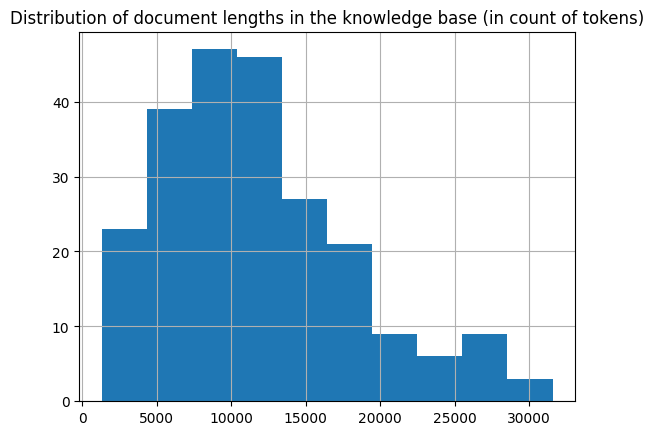

In [6]:
EMBEDDING_MODEL_NAME = "thenlper/gte-small"

from sentence_transformers import SentenceTransformer

print(
    f"Model's maximum sequence length: {SentenceTransformer(EMBEDDING_MODEL_NAME).max_seq_length}"
)

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

### 2. Split the Documents into Chunks

The documents (meeting transcripts) are very long—some up to 30,000 tokens! To make retrieval effective, we’ll **split each document into smaller, semantically meaningful chunks**. These chunks will serve as the snippets the retriever compares to the query, returning the `top_k` most relevant ones.

**Objective**: Create Semantically Relevant Snippets

Chunks should be long enough to capture complete ideas but not so lengthy that they lose focus.

We will use Langchain's implementation of recursive chunking with `RecursiveCharacterTextSplitter`.
- Parameter `chunk_size` controls the length of individual chunks: this length is counted by default as the number of characters in the chunk.
- Parameter `chunk_overlap` lets adjacent chunks get a bit of overlap on each other. This reduces the probability that an idea could be cut in half by the split between two adjacent chunks.

From the produced plot below, you can see that now the chunk length distribution looks better!

Total 18070 snippets to be stored in our vector store.


  0%|          | 0/18070 [00:00<?, ?it/s]

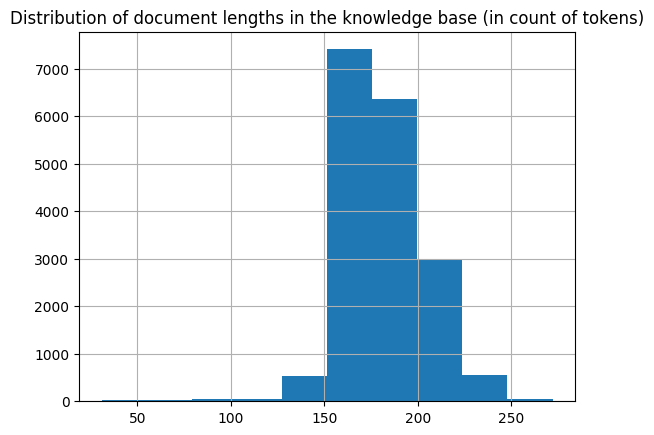

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 768,
    chunk_overlap = 128,
)

doc_snippets = text_splitter.split_documents(docs)
print(f"Total {len(doc_snippets)} snippets to be stored in our vector store.")

lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(doc_snippets)]

# Plot the distribution of document snippet lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

### 3. Build the Vector Database

To enable retrieval, we need to compute embeddings for all chunks in our knowledge base. These embeddings will then be stored in a vector database.

#### How Retrieval Works

A query is embedded using an embedding model and a similarity search finds the closest matching chunks in the vector database.

The following cell builds the vector database consisting of  all chunks in our knowledge base.


In [8]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain_community.vectorstores.utils import DistanceStrategy

# Automatically set the device to 'cuda' if available, otherwise use 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Found device: {device}")


embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": device},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

start_time = time.time()

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    doc_snippets, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

end_time = time.time()

elapsed_time = (end_time - start_time)/60
print(f"Time taken: {elapsed_time} minutes")


Found device: cuda
Time taken: 1.375877022743225 minutes


### 4. Querying the Vector Database


Using LangChain’s vector database,  the function `vector_database.similarity_search(query)` implements a Bi-Encoder (covered in class), independently encoding the query and each document into a single-vector representation, allowing document embeddings to be precomputed.

Let's  define the Bi-Encoder ranking function and then use it on a sample query from the QMSum dataset.



In [9]:
## The function for ranking documents given a query:
def rank_documents_biencoder(user_query, top_k = 1):
    """
    Function for document ranking based on the query.

    :param user_query: The query to retrieve documents for.
    :return: A list of document IDs ranked based on the query (mocked).
    """
    retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=top_k)
    ranked_list = []
    for i, doc in enumerate(retrieved_docs):
        ranked_list.append(retrieved_docs[i].metadata['source'])

    return ranked_list  # ranked document IDs.


user_query = "what did kirsty williams am say about her plan for quality assurance ?"
retrieved_docs = rank_documents_biencoder(user_query)


print("\n==================================Top-1 documents==================================")
print("\n\nRetrieved documents:", retrieved_docs)
print("\n====================================================================\n")


==================================Top-1 documents==================================


Retrieved documents: ['doc_211']




### <font color="red">5. TODO: Implementation of ColBERT as a Reranker for a Bi-Encoder (35 points)</font>

The Bi-Encoder’s ranking for the sample query is not optimal: the ground truth document is not ranked at position 1, instead the document ID, **doc_211** is ranked at position 1.  To determine the correct document ID for this query, refer to the `questions_answers.tsv` file.

In this task, you will implement the [ColBERT](https://arxiv.org/pdf/2004.12832) approach by Khattab and Zaharia. We’ll use a simplified version of ColBERT, focusing on the following key steps:

1. Retrieve the top \( K = 15 \) documents for query \( q \) using the Bi-Encoder.
2. Re-rank these top \( K = 15 \) documents using ColBERT's fine-grained interaction scoring. This will involve:
   - Using frozen BERT embeddings from a HuggingFace BERT model (no training is required, thus our version is not expected to work as well as full-fledged ColBERT).
   - Calculating scores based on fine-grained token-level interactions between the query and each document.
3. Implement the method `rank_documents_finegrained_interactions()` to perform this re-ranking.
   - Test your method on the same query as in the cell from #4 above.
   - Print out the entire re-ranked document list of 5 document IDs, as done in  #4 above (the code below does it for you)
4. Ensure that your ColBERT implementation ranks the correct document at position 1 for the sample query.


***Note***: Since the same document is divided into multiple chunks that retain the original document ID, you may see the same document ID appear multiple times in your top_k results. However, each instance refers to a different chunk of the document's content.

***Note2***: For this PA we are not focused on query latency, just the late interactions part in the ColBERT approach. Thus, we don't have to pre-compute document matrix representations for ColBERT.

***Note3:***: Both the bi-encoder and the ColBERT used in this PA are not trained for retrieval and their performance is therefore not SOTA. What we are doing is  ***zero-shot transfer for retrieval from BERT***. For SOTA retrieval performance both have to be trained on data of the form (q, doc+, docs-). For this PA, it is best to leave the setup as is for grading purposes. But you can certainly explore for your own purposes.


In [12]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel


# Load tokenizer and model BERT from HuggingFace
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")


def rank_documents_finegrained_interactions(user_query, shortlist = 15, top_k=1):

    """
    Rerank the top-K=15 retrieved documents from Bi-encoder using fine-grained token-level interactions
    and return the top_k=5 most similar documents.

    Args:
    - user_query (str): The user query string.
    - shortlist: Number of documents in the longer short list
    - top_k (int): Number of top reranked documents to return.

    Returns:
    - ranked_list of document IDs.
    """

    retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=shortlist)

    query_inputs = tokenizer(user_query, return_tensors='pt', truncation=True, padding=True)

    with torch.no_grad():
        query_embeddings = model(**query_inputs).last_hidden_state
    ranked_list = []



    query_embeddings = query_embeddings.squeeze(0)
    doc_scores = []
    for doc in retrieved_docs:
        doc_inputs = tokenizer(doc.page_content, return_tensors='pt', truncation=True, padding=True)

        with torch.no_grad():
            doc_embeddings = model(**doc_inputs).last_hidden_state
        doc_embeddings = doc_embeddings.squeeze(0)
        sim_scores = torch.matmul(query_embeddings, doc_embeddings.T)
        max_sim_score = sim_scores.max(dim=1).values.mean()
        id = doc.metadata['source']
        doc_scores.append((id, max_sim_score.item()))

    doc_scores.sort(key=lambda x: x[1], reverse=True)

    ranked_list = [doc_id for doc_id, score in doc_scores[:top_k]]

    return ranked_list
user_query = "what did kirsty williams am say about her plan for quality assurance ?"
retrieved_docs = rank_documents_finegrained_interactions(user_query)


print("\n==================================Top-5 documents==================================")
print("\n\nRetrieved documents:", retrieved_docs)
print("\n====================================================================\n")




==================================Top-5 documents==================================


Retrieved documents: ['doc_2']




####<font color="red">6. TODO:  ColBERT Max vs. Mean Pooling for  Relevance Scoring of Documents:</font> (5 points)


ColBERT uses a form of **max pooling**, where each query term's contribution to the relevance score of a  document is determined by its maximum similarity to any document term. One alternative approach is **mean pooling**, where each query term's contribution is calculated as the average similarity across all document terms.

Discuss  the  merits and potential limitations of using  mean pooling versus max pooling in ColBERT. In your answer, consider how each approach might affect retrieval accuracy, sensitivity to specific token matches,  interpretability, and anything you deem relevant. You are welcome to use an analysis of  ColBERT's  performance on the provided sample query in your discussion, but this is not required.


#### <font color="red">Answer (6): (<= 5 sentences) : </font>
Max-pooling emphasises the strongest query document match, which can be good when you want to consider documents with a few key terms that are critical to answering the query. Since the max-pooling only takes into account a single term from the document, it might not doesn't consider the overall content of the document.

Mean-pooling can be beneficial when the most important factor is the query's overall alignment to all terms in the document (and not just a single term). mean-pooling therefore gives a better sense of how a relevant a document is for answering the full range of the query.


----------------------------
# <font color="blue"> Submission Instructions</font>
---------------------------

1. Click the Save button at the top of the Jupyter Notebook.
2. Select Runtime -> Run All. This will run all the cells in order, and will take several minutes.
3. Once you've rerun everything,  save a PDF version of your notebook. Make sure all your code and answers  are displayed in the pdf</font>, it's okay if the provided codes get cut off because lines are not wrapped in code cells).
4. Look at the PDF file and make sure all your code and answers  are there, displayed correctly. The PDF is the only thing your graders will see!
5. Submit your PDF on Gradescope.

### <font color="green">  7.  (Optional) Full evaluation pipeline for your own exploration. </font>


For this assignment, we only ask you to explore  one  sample query.
Running on many queries is super slow without the right compute.
If you have compute/and/or time to wait, below is a more complete evaluation setup that works with all the queries in QMSum dataset, and  reports the  `precision@k=5` metric.


**Note**: you need to remove the comment markers from the code below.

In [ ]:

# def load_questions_answers(qa_file):
#     """
#     Loads the questions and corresponding ground truth document IDs.

#     :param qa_file: Path to the question-answer file (document ID <TAB> question <TAB> answer).
#     :return: A list of tuples [(document_id, question, answer)].
#     """
#     qa_pairs = []
#     with open(qa_file, 'r', encoding='utf-8') as f:
#         reader = csv.reader(f, delimiter='\t')
#         for row in reader:
#             doc_id, question, answer = row
#             qa_pairs.append((doc_id, question, answer))

#     random.shuffle(qa_pairs)

#     return qa_pairs

# def precision_at_k(ground_truth, retrieved_docs, k):
#     """
#     Computes Precision at k for a single query.

#     :param ground_truth: The name of the ground truth document.
#     :param retrieved_docs: The list of document names returned by the model in ranked order.
#     :param k: The cutoff for computing Precision.
#     :return: Precision at k.
#     """
#     return 1 if ground_truth in retrieved_docs[:k] else 0

# def evaluate(doc_file, qa_file, ranking_fuction = None, k= 5):
#     """
#     Evaluate the retrieval system based on the documents and question-answer pairs.

#     :param doc_file: Path to the document file.
#     :param qa_file: Path to the question-answer file.
#     :param k: The cutoff for Precision@k.
#     """
#     # Load the QA pairs
#     qa_pairs = load_questions_answers(qa_file)

#     precision_scores = []


#     for doc_id, question, _ in qa_pairs:

#         retrieved_docs = ranking_fuction(question)
#         precision_scores.append(precision_at_k(doc_id, retrieved_docs, k))

#         avg_precision_at_k = sum(precision_scores) / len(precision_scores)

#         if len(precision_scores) %10==0:
#             print(f"After {len(precision_scores)} queries, Precision@{k}: {avg_precision_at_k}")

#     # Compute average Precision@k
#     avg_precision_at_k = sum(precision_scores) / len(precision_scores)

#     print(f"Precision@{k}: {avg_precision_at_k}")


# qa_file = 'questions_answers.tsv'  # document ID <TAB> question <TAB> answer

# start_time = time.time()
# evaluate(doc_file, qa_file,rank_documents_biencoder)
# end_time = time.time()
# elapsed_time = (end_time - start_time)/60
# print(f"Time taken: {elapsed_time} minutes")